In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from sklearn. metrics import f1_score

# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/MyDrive/INTACT

camera1-20230327T162302Z-001.zip  camera2-20230327T162419Z-001.zip
camera1_label_norm.zip		  camera2_label_norm.zip


In [ ]:
!unzip /content/gdrive/MyDrive/INTACT/camera1-20230327T162302Z-001.zip

Archive:  /content/gdrive/MyDrive/INTACT/camera1-20230327T162302Z-001.zip
  inflating: camera1/no-defects-11_28_32-12.12.2022.png  
  inflating: camera1/no-defects-11_46_21-20.12.2022.png  
  inflating: camera1/no-defects-11_46_32-20.12.2022.png  
  inflating: camera1/no-defects-06_45_22-13.12.2022.png  
  inflating: camera1/no-defects-11_30_39-12.12.2022.png  
  inflating: camera1/no-defects-11_48_12-20.12.2022.png  


In [ ]:
!unzip /content/gdrive/MyDrive/INTACT/camera2-20230327T162419Z-001.zip

Archive:  /content/gdrive/MyDrive/INTACT/camera2-20230327T162419Z-001.zip
  inflating: camera2/no-defects-14_29_21-29.11.2022 (1).png  
  inflating: camera2/no-defects-14_40_21-13.12.2022.png  
  inflating: camera2/no-defects-14_40_18-13.12.2022.png  
  inflating: camera2/no-defects-14_29_14-29.11.2022.png  
  inflating: camera2/no-defects-13_56_04-18.01.2023.png  
  inflating: camera2/no-defects-14_41_53-13.12.2022.png  


In [ ]:
!unzip /content/gdrive/MyDrive/INTACT/camera1_label_norm.zip

Archive:  /content/gdrive/MyDrive/INTACT/camera1_label_norm.zip
  inflating: camera1_label_norm/no-defects-06_45_22-13.12.2022_label_norm.png  
  inflating: camera1_label_norm/no-defects-11_28_32-12.12.2022_label_norm.png  
  inflating: camera1_label_norm/no-defects-11_30_39-12.12.2022_label_norm.png  
  inflating: camera1_label_norm/no-defects-11_46_21-20.12.2022_label_norm.png  
  inflating: camera1_label_norm/no-defects-11_46_32-20.12.2022_label_norm.png  
  inflating: camera1_label_norm/no-defects-11_48_12-20.12.2022_label_norm.png  


In [ ]:
!unzip /content/gdrive/MyDrive/INTACT/camera2_label_norm.zip

Archive:  /content/gdrive/MyDrive/INTACT/camera2_label_norm.zip
  inflating: camera2_label_norm/no-defects-13_56_04-18.01.2023_label_norm.png  
  inflating: camera2_label_norm/no-defects-14_29_14-29.11.2022_label_norm.png  
  inflating: camera2_label_norm/no-defects-14_29_21-29.11.2022 (1)_label_norm.png  
  inflating: camera2_label_norm/no-defects-14_40_18-13.12.2022_label_norm.png  
  inflating: camera2_label_norm/no-defects-14_40_21-13.12.2022_label_norm.png  
  inflating: camera2_label_norm/no-defects-14_41_53-13.12.2022_label_norm.png  


In [ ]:
def get_img(root, label=False):
    imgs = []

    r, dirs, a = next(iter(os.walk(root)))
    a.sort()
    for file in a:
            jpg_img = cv2.cvtColor(cv2.imread(os.path.join(r, file)), cv2.COLOR_RGBA2BGR)
            jpg_img = cv2.cvtColor(jpg_img, cv2.COLOR_BGR2RGB)
            if label:
                jpg_img = cv2.cvtColor(jpg_img, cv2.COLOR_BGR2GRAY)
                ret, jpg_img = cv2.threshold(jpg_img, 0, 255, cv2.THRESH_BINARY)
            imgs.append(jpg_img)

    return imgs

In [ ]:
images1 = get_img('/content/camera1')
images2 = get_img('/content/camera2')
labels_1 = get_img('/content/camera1_label_norm', True)
labels_2 = get_img('/content/camera2_label_norm', True)

In [ ]:
len(images1), len(images2), len(labels_1), len(labels_2)

(6, 6, 6, 6)

In [ ]:
bright1 = [i.sum()/(i.shape[0]*i.shape[1]*i.shape[2]) for i in images1]
bright1

[70.92141942613907,
 72.59508262444808,
 72.50879286543078,
 69.57939379257198,
 71.5063459226179,
 70.42921360472006]

In [ ]:
bright2 = [i.sum()/(i.shape[0]*i.shape[1]*i.shape[2]) for i in images2]
bright2

[60.356823188402245,
 80.2074993807973,
 80.97353544734959,
 74.3630873614339,
 75.06804327069125,
 74.4922531215042]

У первой фотографии камеры 2 значитильно отличается освещённость. 
Увеличм её для, чтоб thresholding работал аналогично другим:

In [ ]:
images2[0] = cv2.convertScaleAbs(images2[0], alpha=1.4, beta=0)
images2[0].sum()/(6373*4096*3)

84.00453910785737

Также при содании лэйблов ненамеренно изменился размер первого лэйбла камеры 1, поэтому нужно ресайзнуть его.

In [ ]:
labels_1[0].shape

(5520, 4640)

In [ ]:
center = labels_1[0].shape
w, h = 4096, 5240
x = center[1]/2 - w/2 + 70
y = center[0]/2 - h/2 - 20
labels_1[0] = labels_1[0][int(y):int(y+h), int(x):int(x+w)]

In [ ]:
labels_1[0].shape

(5240, 4096)

# Создаём функции для обработки и сегментации, а также визуализации:   

In [ ]:
def thresh(image, show=False):
    # image = cv2.ximgproc.anisotropicDiffusion(image, 0.075, 80, 10)
    # image=cv2.fastNlMeansDenoisingColored(image,None, 10, 10, 7, 3)
    image = cv2.convertScaleAbs(image, alpha=2, beta=0)
    image = cv2.GaussianBlur(image, (7,7), 0)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE)
    thresh = cv2.medianBlur(thresh, 27)
    thresh = cv2.medianBlur(thresh, 11)

    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(thresh, cmap='gray')

    return thresh

In [ ]:
def morph(image, camera, show=False):  

    if camera == 1:
        N_close, width, N_open = 51, 150, 1
    else:   
        N_close, width, N_open = 100, 100, 2

    image = thresh(image)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [3,3])
    erode = cv2.erode(image, kernel, iterations=1)
    close = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, kernel, iterations = N_close) 

    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [width, 10]) 
    morph_gradient = cv2.morphologyEx(close, cv2.MORPH_TOPHAT, kernel3)

    vanish = cv2.morphologyEx(morph_gradient, cv2.MORPH_OPEN,   kernel, iterations = 1)
    kl = cv2.getStructuringElement(cv2.MORPH_CROSS, [1, 50]) 
    vanish = cv2.morphologyEx(vanish, cv2.MORPH_OPEN,   kl, iterations = N_open) 
    if camera == 2:
        vanish = cv2.erode(vanish, kernel, iterations=5) 

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [3,4])
    kernel[3][0], kernel[3][2] = 0, 0
    out = cv2.dilate(vanish, kernel, iterations=27)
    if show:
        plt.figure(figsize=(24,10))
        plt.subplot(1, 4, 1)
        plt.imshow(image, cmap='gray')
        plt.subplot(1, 4, 2)
        plt.imshow(close, cmap='gray')
        plt.subplot(1, 4, 3)
        plt.imshow(vanish, cmap='gray')
        plt.subplot(1, 4, 4)
        plt.imshow(out, cmap='gray')

    return out

In [ ]:
def compare(labels, outs, iou_scores, f1_scores):
    plt.figure(figsize=(24,20))
    for i in range(len(outs)):      
        plt.subplot(3, 4, (i*2)+1)
        plt.title('label_%s' % str(i+1))
        plt.imshow(labels[i], cmap='gray')
        plt.subplot(3, 4, (i*2)+2)
        plt.title('out_{n:01d}: IoU = {iou:0.2f}, F1 = {f1:0.2f}'.format(n=i+1, iou=iou_scores[i], f1=f1_scores[i]))
        plt.imshow(outs[i], cmap='gray')

In [ ]:
outs1 = [morph(i, 1) for i in images1]

In [ ]:
outs2 = [morph(i, 2) for i in images2]

In [ ]:
shapes1 = [(labels_1[i].shape, outs1[i].shape) for i in range(6)]
shapes2 = [(labels_2[i].shape, outs2[i].shape) for i in range(6)]

In [ ]:
shapes1

[((5240, 4096), (5240, 4096)),
 ((6483, 4096), (6483, 4096)),
 ((6484, 4096), (6484, 4096)),
 ((6478, 4096), (6478, 4096)),
 ((6478, 4096), (6478, 4096)),
 ((6381, 4096), (6381, 4096))]

In [ ]:
shapes2

[((6373, 4096), (6373, 4096)),
 ((6482, 4096), (6482, 4096)),
 ((6374, 4096), (6374, 4096)),
 ((6481, 4096), (6481, 4096)),
 ((6378, 4096), (6378, 4096)),
 ((6481, 4096), (6481, 4096))]

# Рассчёт метрик IoU и F1:

In [ ]:
def get_IoU(label, pred):
    intersection = np.logical_and(label, pred)
    union = np.logical_or(label, pred)
    SMOOTH = 1e-8
    iou_score = (np.sum(intersection)+SMOOTH)/(np.sum(union)+SMOOTH)
    # print('IoU is %s' % round(iou_score, 3))
    return round(iou_score, 3)

In [ ]:
iou_scores1 = [get_IoU(labels_1[i], outs1[i]) for i in range(6)]
iou_scores2 = [get_IoU(labels_2[i], outs2[i]) for i in range(6)]

In [ ]:
iou_scores1 = [get_IoU(labels_1[i], outs1[i]) for i in range(6)]
iou_scores2 = [get_IoU(labels_2[i], outs2[i]) for i in range(6)]
f1_scores1 = [round(f1_score(labels_1[i], outs1[i], average='micro', zero_division=1), 3) for i in range(6)]
f1_scores2 = [round(f1_score(labels_2[i], outs2[i], average='micro', zero_division=1), 3) for i in range(6)]

In [ ]:
for i in range(6):
    print('Camera1 Image №{n:01d}: IoU = {iou:0.3f} and F1 = {f1:0.3f}'.format(n=i+1, iou=iou_scores1[i], f1=f1_scores1[i]))
    print()

Camera1 Image №1: IoU = 0.832 and F1 = 0.908

Camera1 Image №2: IoU = 0.000 and F1 = 0.000

Camera1 Image №3: IoU = 0.319 and F1 = 0.484

Camera1 Image №4: IoU = 0.571 and F1 = 0.727

Camera1 Image №5: IoU = 0.403 and F1 = 0.574

Camera1 Image №6: IoU = 0.125 and F1 = 0.223



In [ ]:
for i in range(6):
    print('Camera2 Image №{n:01d}: IoU = {iou:0.3f} and F1 = {f1:0.3f}'.format(n=i+1, iou=iou_scores2[i], f1=f1_scores2[i]))
    print()

Camera2 Image №1: IoU = 0.652 and F1 = 0.790

Camera2 Image №2: IoU = 1.000 and F1 = 1.000

Camera2 Image №3: IoU = 0.000 and F1 = 0.000

Camera2 Image №4: IoU = 0.673 and F1 = 0.805

Camera2 Image №5: IoU = 0.626 and F1 = 0.770

Camera2 Image №6: IoU = 0.651 and F1 = 0.788



Хорошие результаты для камеры 2 и приемлемы для камеры 1. Однако есть по одному изображению в каждой папке, где дефекты маленьких размеров, которые не удалось сегментировать, что занулировало точность в этих случаях. Есть идея создать костомную метрику, которая бы учитывала два взвешенных фактора: первый - IoU или F1, второй - TP (количество правильно определённых пикселей). Взвешивание определялось бы нелинейной функцции доли кол-ва пикселей дефектов i-го лэйбла к максимальному кол-ву пикселей дефектов среди всех лэйблов.

### Отаброжение процесса сегментации изображения

Пример для камеры 1:

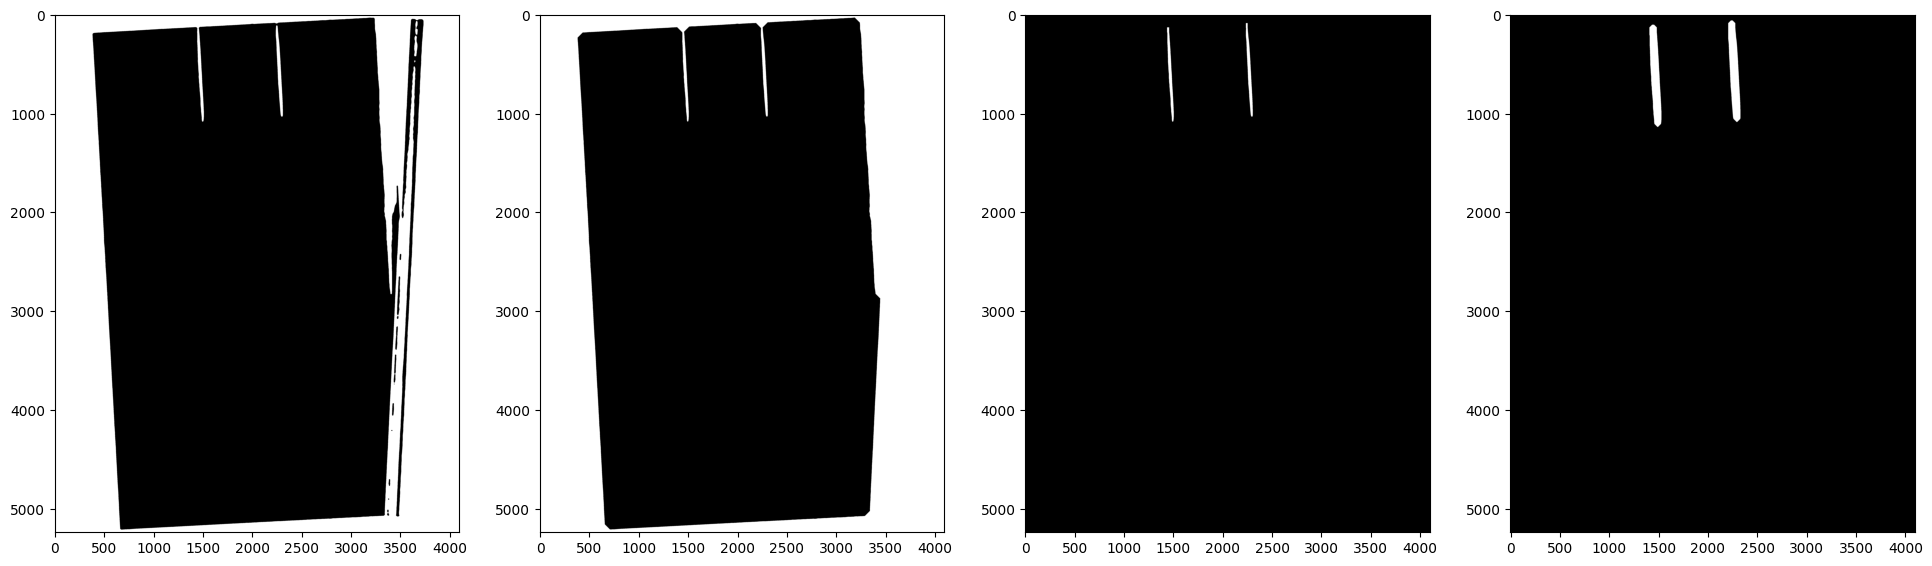

In [ ]:
_ = morph(images1[0], 1, show=True)

Пример для камеры 2:

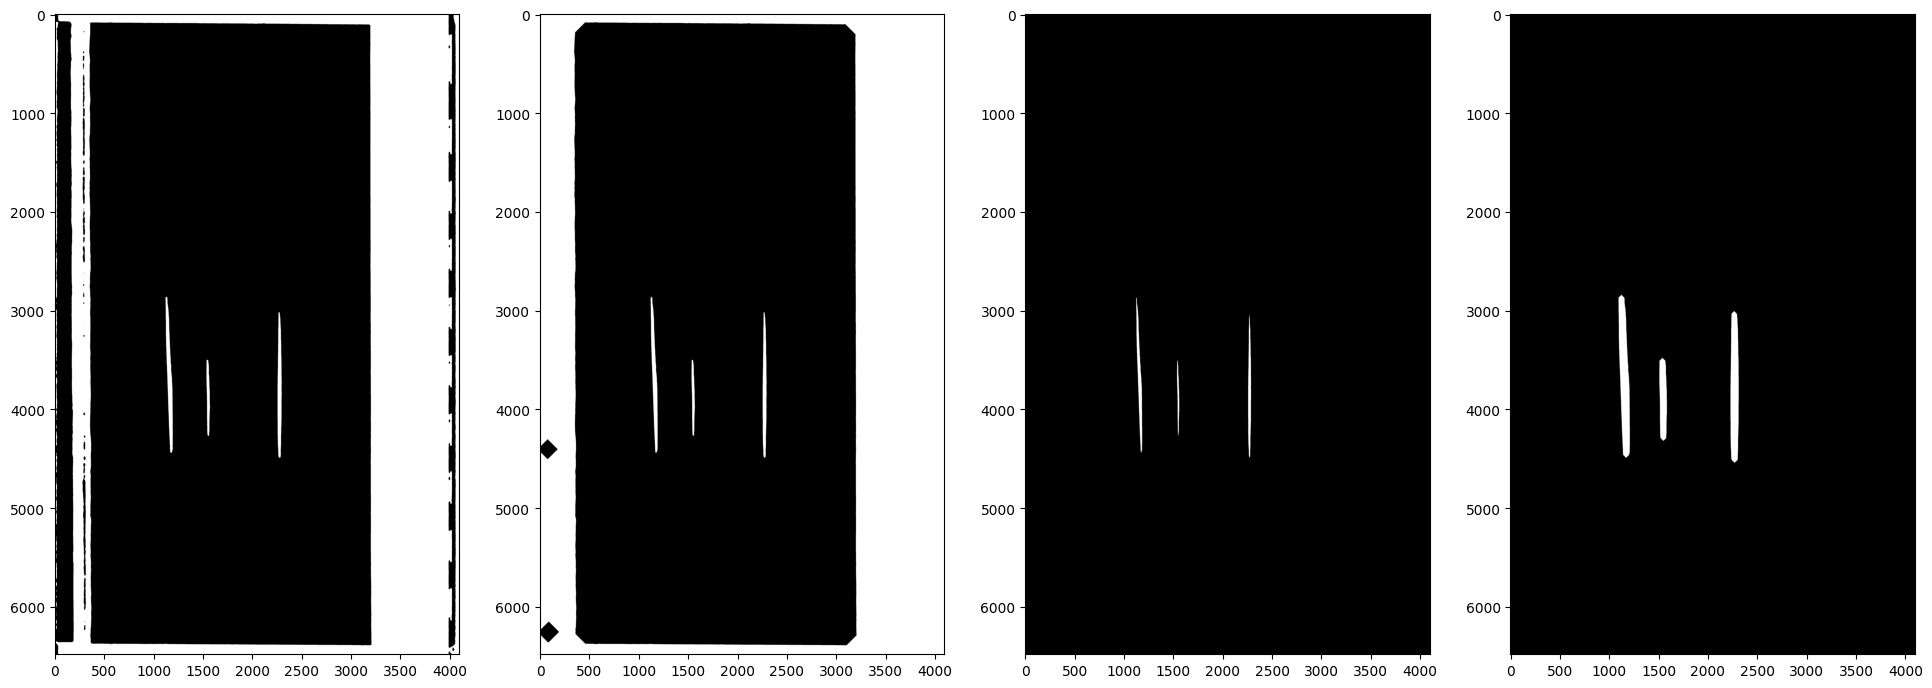

In [ ]:
_ = morph(images2[5], 2, show=True)

# Сравнение полученных результатов с ground thruth:

Камера 1

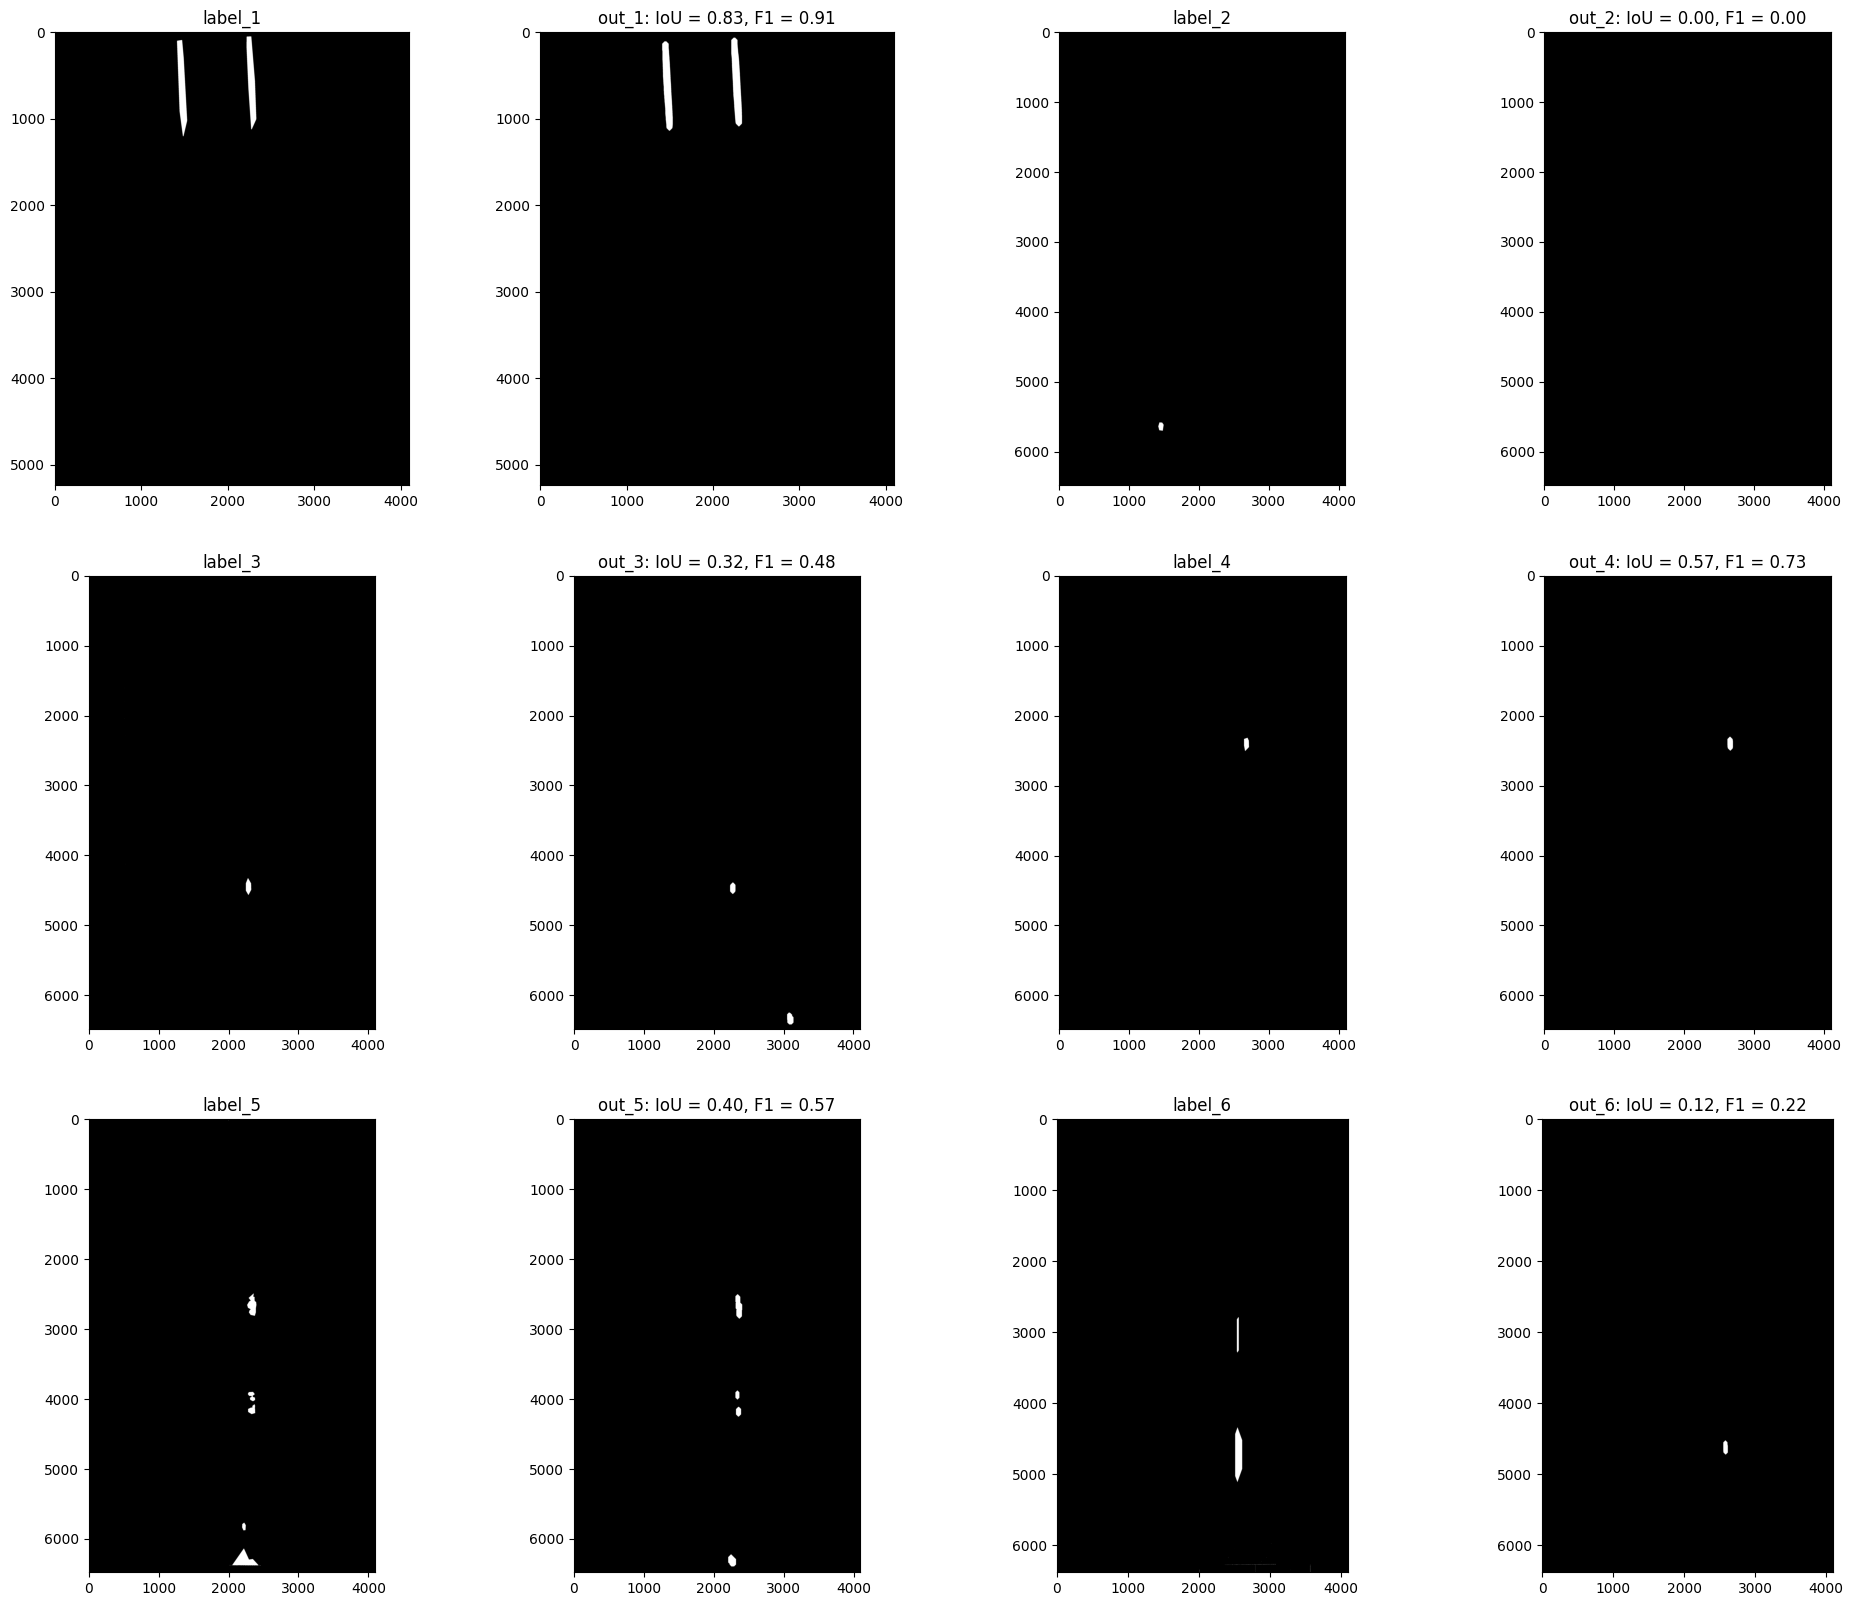

In [ ]:
compare(labels_1, outs1, iou_scores1, f1_scores1)

Камера 2

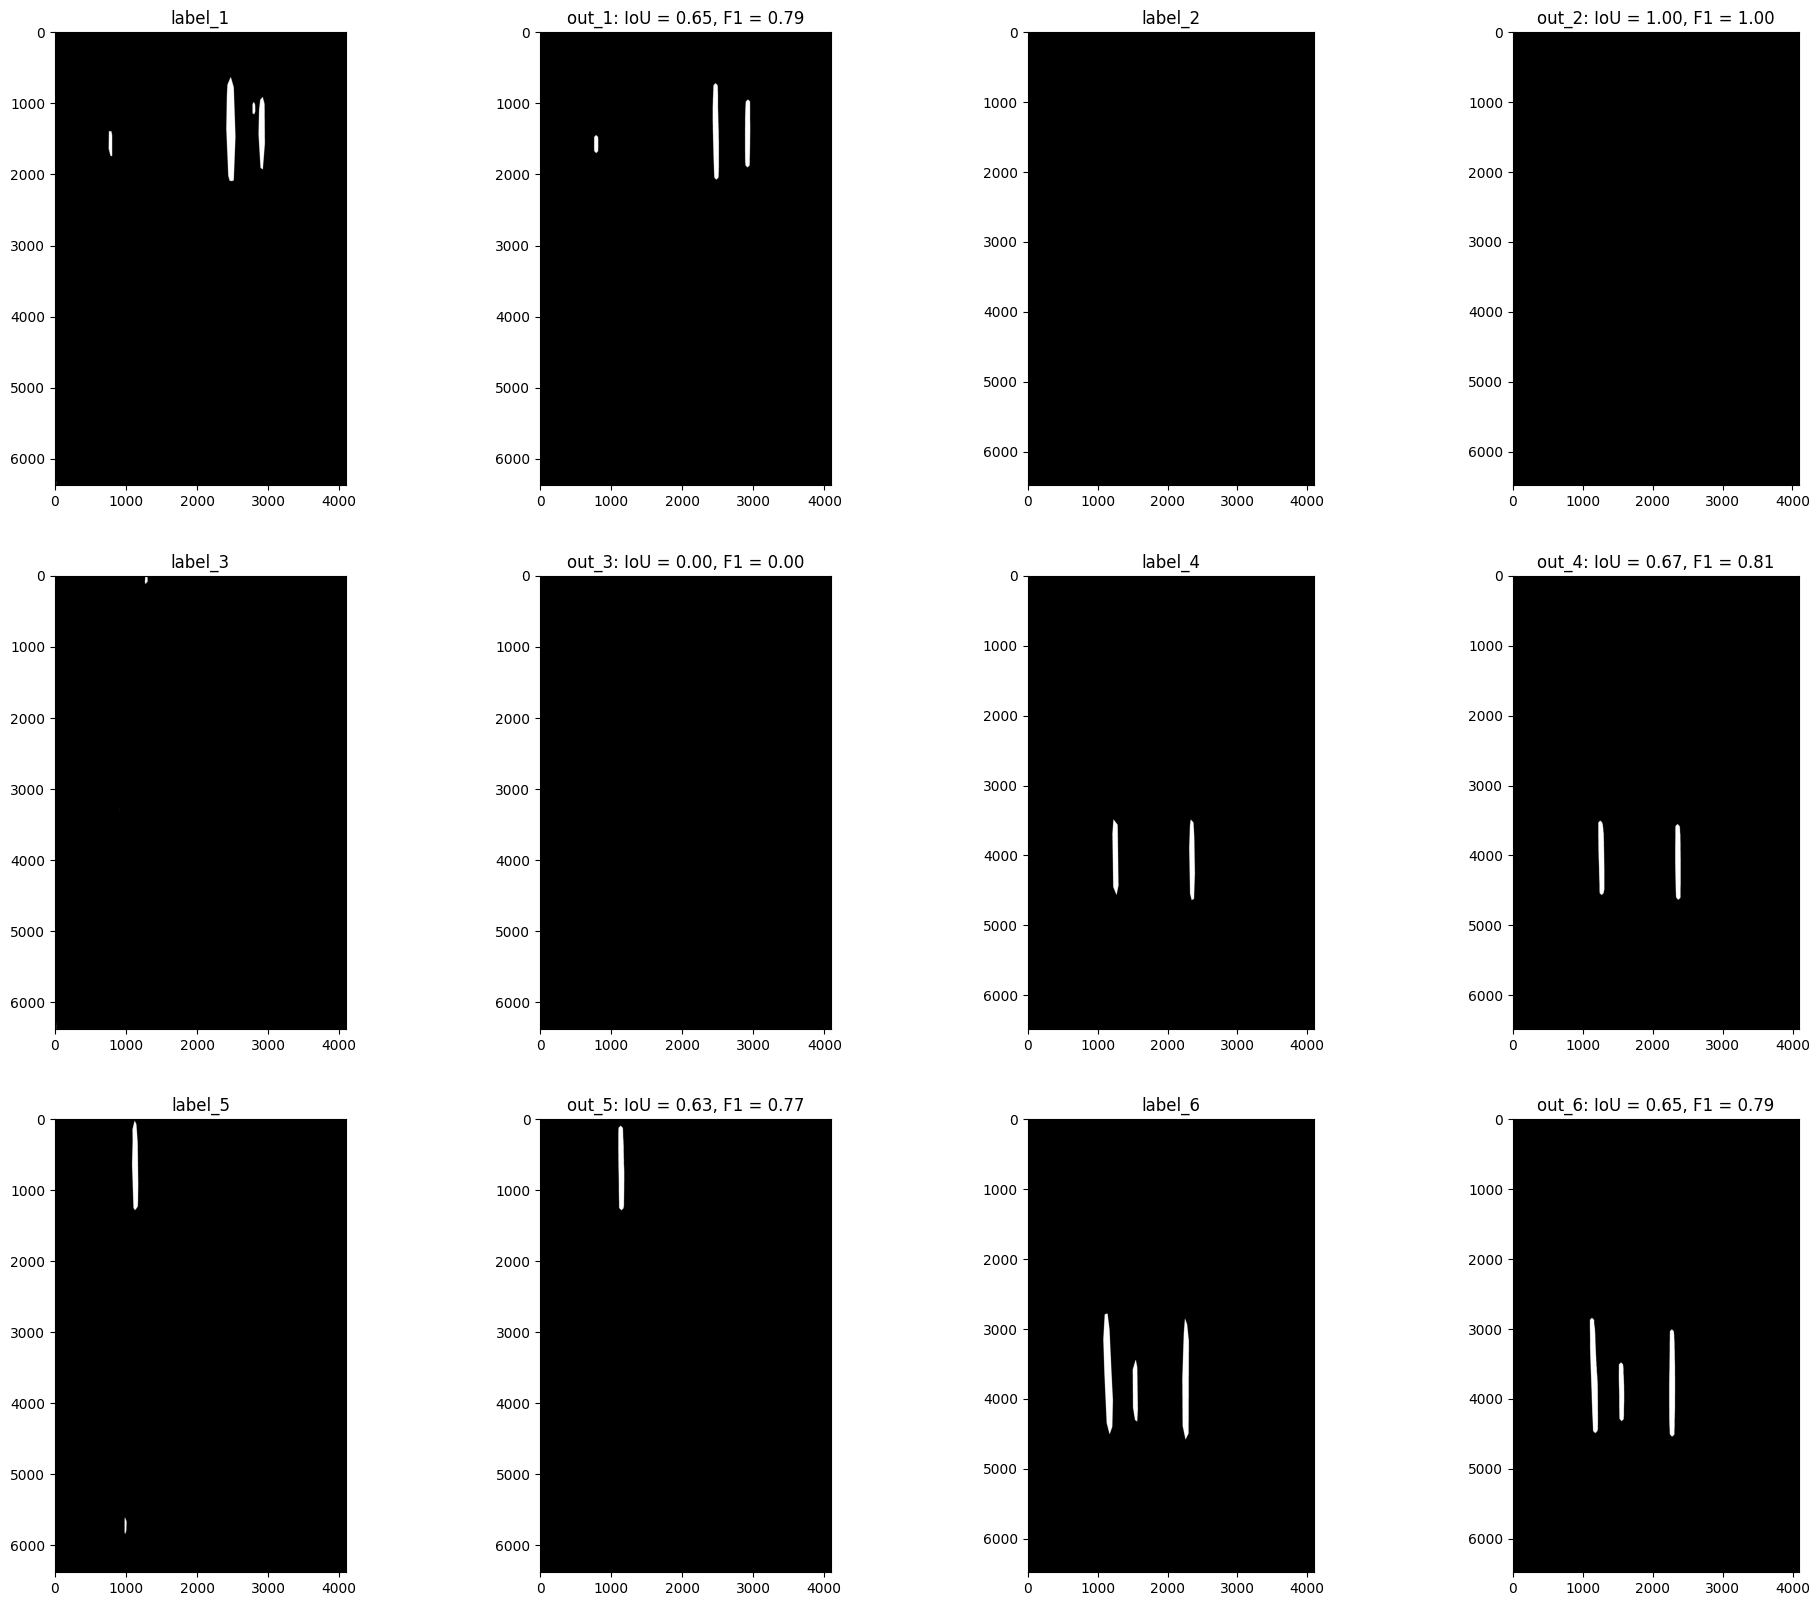

In [ ]:
compare(labels_2, outs2, iou_scores2, f1_scores2)

# Способ реализации с использования алгоритма MeanShift

In [ ]:
def morph_sh(image, camera, show=False):  #nice

    N_close, width, N_open = 100, 100, 2

    image = threshift(image, camera)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [3,3])
    erode = cv2.erode(image, kernel, iterations=1)
    close = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, kernel, iterations = N_close) #51

    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [width, 10]) #150
    morph_gradient = cv2.morphologyEx(close, cv2.MORPH_TOPHAT, kernel3)

    vanish = cv2.morphologyEx(morph_gradient, cv2.MORPH_OPEN,   kernel, iterations = 1)
    kl = cv2.getStructuringElement(cv2.MORPH_CROSS, [1, 50]) 
    vanish = cv2.morphologyEx(vanish, cv2.MORPH_OPEN, kl, iterations = N_open) 
    vanish = cv2.erode(vanish, kernel, iterations=7) 
    

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [3,4])
    kernel[3][0], kernel[3][2] = 0, 0
    out = cv2.dilate(vanish, kernel, iterations=27)
    if show:
        plt.figure(figsize=(24,10))
        plt.subplot(1, 4, 1)
        plt.imshow(image, cmap='gray')
        plt.subplot(1, 4, 2)
        plt.imshow(close, cmap='gray')
        plt.subplot(1, 4, 3)
        plt.imshow(vanish, cmap='gray')
        plt.subplot(1, 4, 4)
        plt.imshow(out, cmap='gray')

    return out

In [ ]:
def threshift(image, camera):

    image = cv2.pyrMeanShiftFiltering(src=image,sp=21,sr=30)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if camera == 1:
        image = cv2.medianBlur(image, 57)
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 127, 2) #1
    else:
        ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #2
    
    return image

In [ ]:
outs1_sh = [morph_sh(i, 1) for i in images1]

In [ ]:
outs2_sh = [morph_sh(i, 2) for i in images2] 

In [ ]:
iou_scores1_sh = [get_IoU(labels_1[i], outs1_sh[i]) for i in range(6)]
iou_scores2_sh = [get_IoU(labels_2[i], outs2_sh[i]) for i in range(6)]
f1_scores1_sh = [round(f1_score(labels_1[i], outs1_sh[i], average='micro', zero_division=1), 3) for i in range(6)]
f1_scores2_sh = [round(f1_score(labels_2[i], outs2_sh[i], average='micro', zero_division=1), 3) for i in range(6)]

In [ ]:
for i in range(6):
    print('Camera1 Image №{n:01d}: IoU = {iou:0.3f} and F1 = {f1:0.3f}'.format(n=i+1, iou=iou_scores1_sh[i], f1=f1_scores1_sh[i]))
    print()

Camera1 Image №1: IoU = 0.661 and F1 = 0.796

Camera1 Image №2: IoU = 0.000 and F1 = 0.000

Camera1 Image №3: IoU = 0.000 and F1 = 0.000

Camera1 Image №4: IoU = 0.318 and F1 = 0.483

Camera1 Image №5: IoU = 0.139 and F1 = 0.244

Camera1 Image №6: IoU = 0.304 and F1 = 0.466



In [ ]:
for i in range(6):
    print('Camera2 Image №{n:01d}: IoU = {iou:0.3f} and F1 = {f1:0.3f}'.format(n=i+1, iou=iou_scores2_sh[i], f1=f1_scores2_sh[i]))
    print()

Camera2 Image №1: IoU = 0.529 and F1 = 0.692

Camera2 Image №2: IoU = 1.000 and F1 = 1.000

Camera2 Image №3: IoU = 0.000 and F1 = 0.000

Camera2 Image №4: IoU = 0.559 and F1 = 0.717

Camera2 Image №5: IoU = 0.569 and F1 = 0.725

Camera2 Image №6: IoU = 0.574 and F1 = 0.729



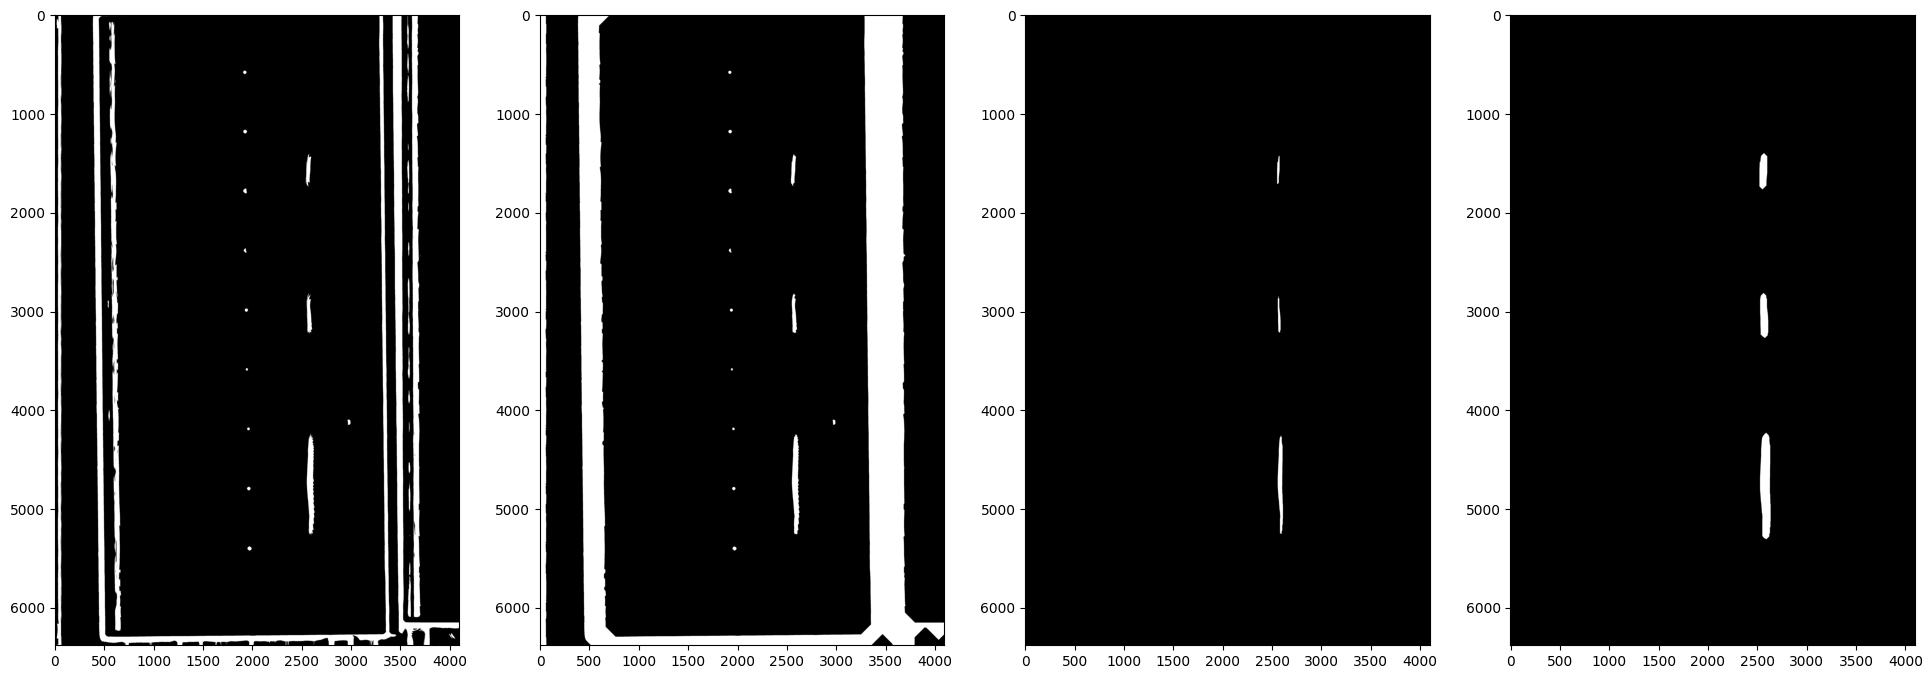

In [ ]:
_ = morph_sh(images1[5], 1, show=True)

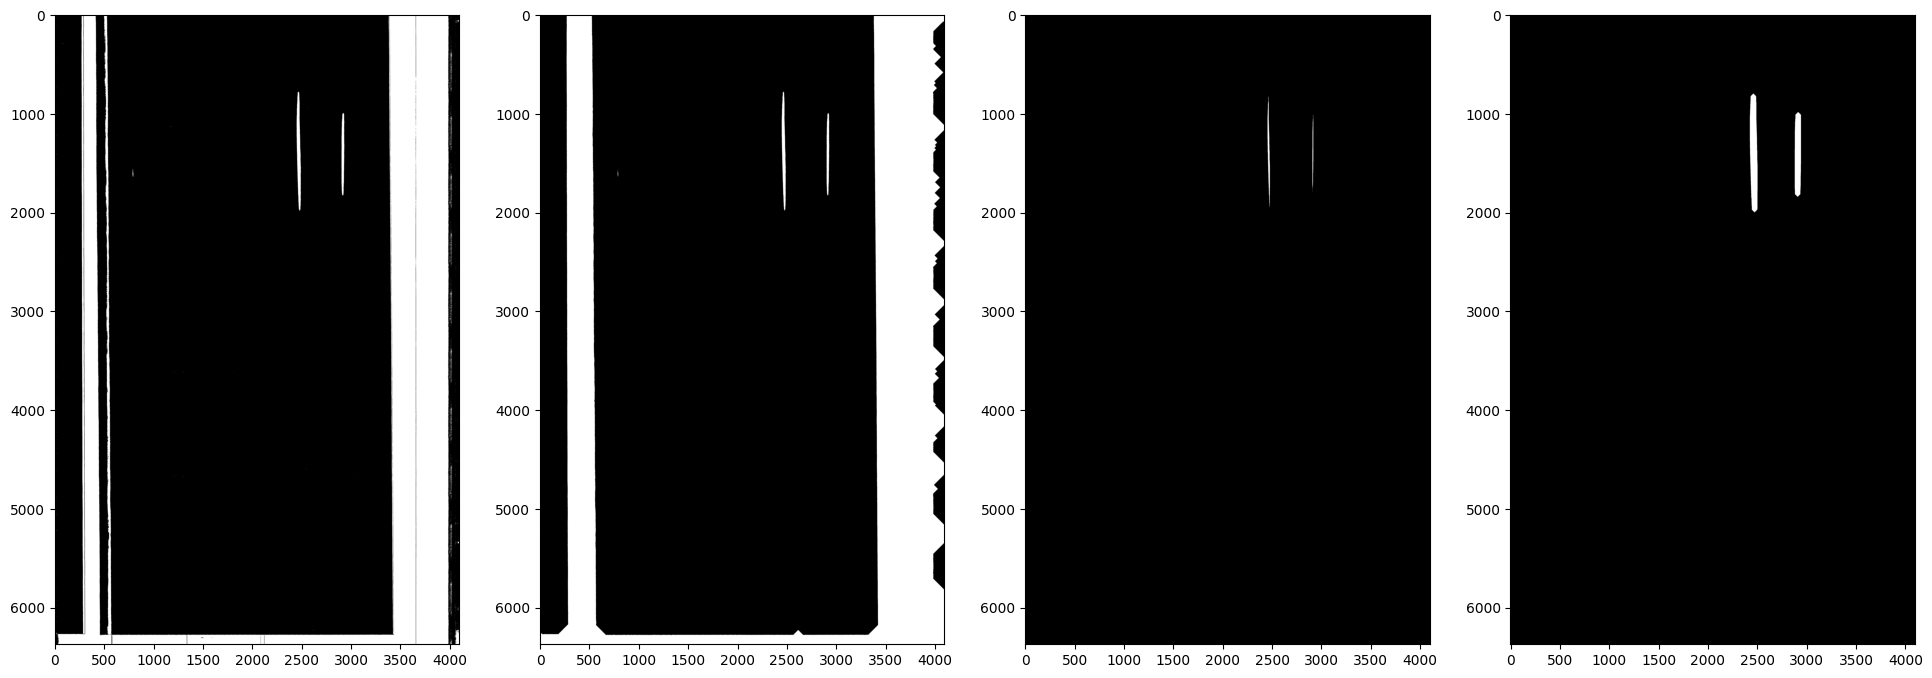

In [ ]:
_ = morph_sh(images2[0], 2, show=True)

Камера 1

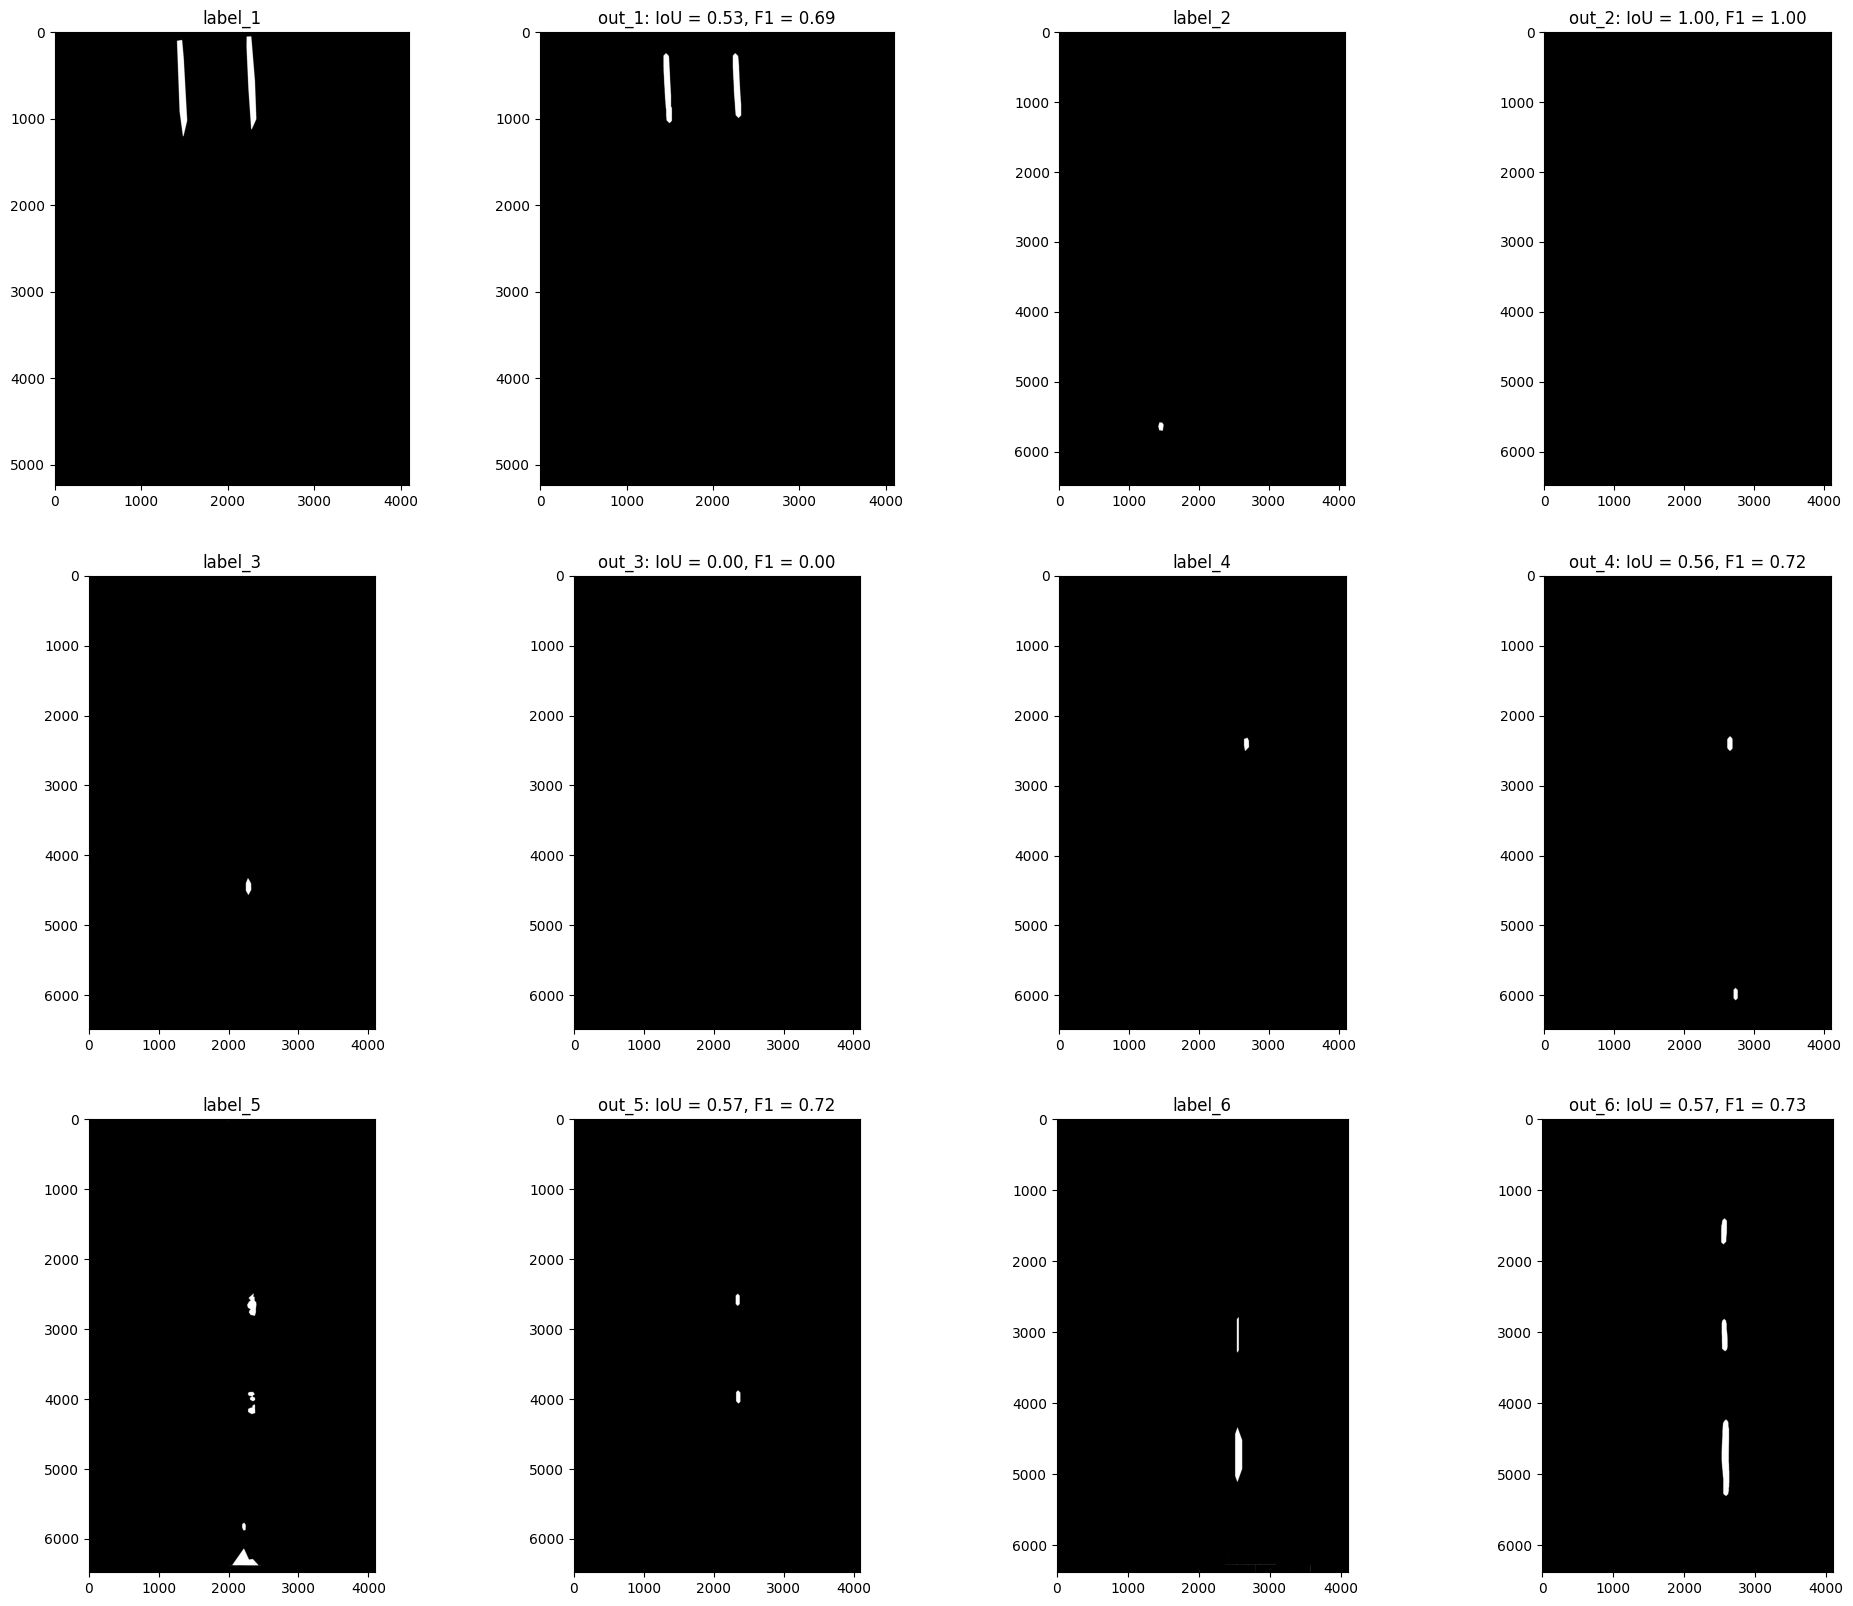

In [ ]:
compare(labels_1, outs1_sh, iou_scores2_sh, f1_scores2_sh)

Камера 2

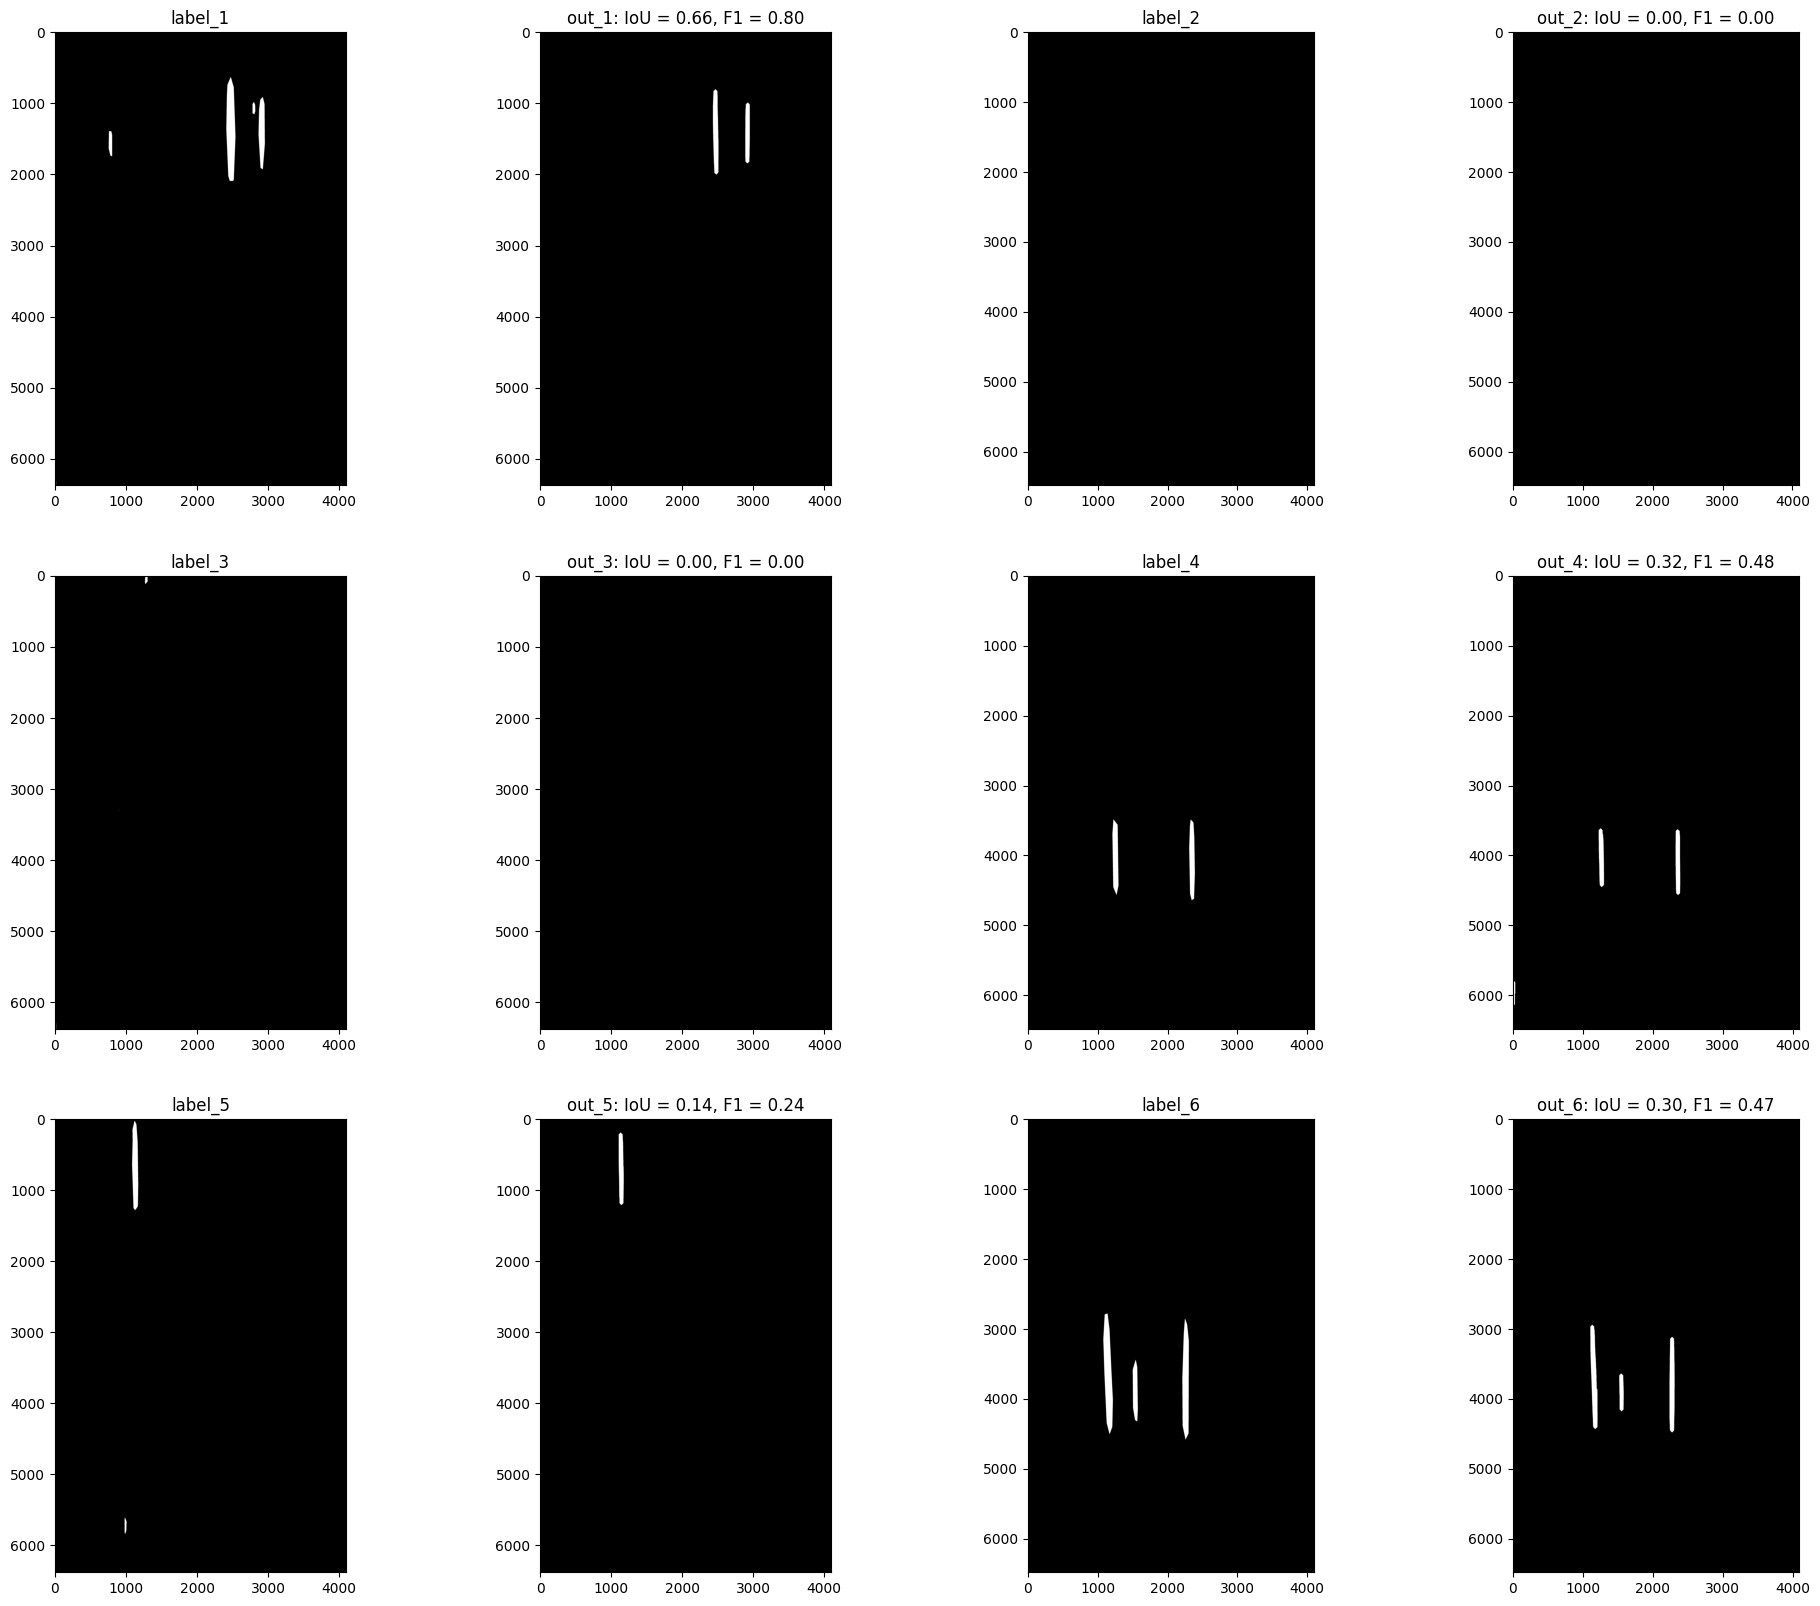

In [ ]:
compare(labels_2, outs2_sh, iou_scores1_sh, f1_scores1_sh)

В целом, способ вышел немного хуже, но в случае с вмятинами (шестой снимок камеры 2) получилось сегментировать все дефекты.